# Mandatory assignment 2

# Exercise 1, Regression problem

A data set contains 24 predictors, 496 data points and 1 continuous output: forced vital capacity. The data will be analyzed with various machine learning methods in Python.

## 1.1 Processing the data set
In the code below, the data set is processed:
1. The data set is split into training and test sets with a 50/50 split (248 data points in each subset).
2. The sets are split into continuous and categorical values.
3. The continuous predictors are standardized (mean=0, std=1).
4. The categorical values are kept in their binary fashion, ($y_i \in \{0,1\}$)


In [98]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]


df = pd.read_csv("./data/ozone_496obs_25vars.txt", sep=" ")
names = list(df)

# ----- Split of training and test -----
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)
N_train = len(train_df.index)
N_test = len(test_df.index)

# These columns only contains binary values (0 or 1)
categorcal_indices = [1, 2, 3, 4, 5, 6, 7, 9, 13, 14, 17, 19, 20, 22, 23]
# These columns contains continuous variables
continuous_indices = [0, 8, 10, 11, 12, 15, 16, 18, 21, 24]
categorcal_names = []
continuous_names = []

for i in range(25):
    if i in categorcal_indices:
        categorcal_names.append(names[i])
    else:
        continuous_names.append(names[i])

# ----- Scaling of columns -----
# Scale columns so that mean=0, std=1
scl = StandardScaler(with_mean=True, with_std=True)
# Scale both the train/test according to training set:
scl.fit(train_df) 
train_df = pd.DataFrame(scl.transform(train_df), columns=all_names)
test_df = pd.DataFrame(scl.transform(test_df), columns=all_names)

Now would be a good time to look at the processed data:

In [24]:
print(f"\tTrain data: {N_train} data points")
print(f"\tTest data: {N_test} data points\n")

print("\tContinuous columns.")
print("\tCovariant  Train mean  Train std  Test mean  Test std")
print("\t-----------------------------------------------------")
for name in all_names:
    if name in continuous_names:
        tr_mean = np.mean(train_df[name])
        tr_std = np.std(train_df[name])
        te_mean = np.mean(test_df[name])
        te_std = np.std(test_df[name])
        print(f"\t{name:7}    {tr_mean:6.2e}    {tr_std:6.2f}  ", end="")
        print(f"  {te_mean:6.2e}   {te_std:6.2f}")

print("\n\tCategorical columns")
print("\tCovariant  Train ones  Train zeros  Test ones  Test zeros")
print("\t---------------------------------------------------------")
for name in all_names:
    if name in categorcal_names:
        tr_ones = int(np.sum(train_df[name].values > 0))
        tr_zeros = int(N_train - tr_ones)
        te_ones = int(np.sum(test_df[name].values > 0))
        te_zeros = int(N_test - te_ones)
        print(f"\t{name:7}    {tr_ones}        ",  end="")
        print(f" {tr_zeros}           {te_ones}        {te_zeros}")

	Train data: 248 data points
	Test data: 248 data points

	Continuous columns.
	Covariant  Train mean  Train std  Test mean  Test std
	-----------------------------------------------------
	ALTER      6.72e-17      1.00    -2.48e-01     0.60
	AGEBGEW    5.81e-17      1.00    -1.70e-02     0.97
	FLGROSS    1.54e-16      1.00    1.25e-01     1.05
	FMILB      -4.77e-17      1.00    3.59e-02     0.97
	FNOH24     4.36e-17      1.00    2.46e-18     1.00
	FLTOTMED    -8.95e-17      1.00    9.89e-02     1.10
	FO3H24     -3.19e-16      1.00    1.75e-02     0.99
	FTEH24     3.22e-17      1.00    3.76e-02     1.08
	FLGEW      5.26e-16      1.00    1.27e-01     1.22
	FFVC       -4.07e-16      1.00    3.07e-02     1.05

	Categorical columns
	Covariant  Train ones  Train zeros  Test ones  Test zeros
	---------------------------------------------------------
	ADHEU      122         126           122        126
	SEX        19         229           18        230
	HOCHOZON    134         114           1

Two remarks regarding the processed data:
1. Continuous predictors: The test set is scaled according to the training set, therefore the mean/std values in the test set is not as close to 1 and 0 as the mean/std are in the training set. This is as expected.
2. Categorical predictors: The number of ones in the train and test set are very good distributed (no more imbalanced split than 60 % / 40 %).

Split of the data into X and y:

In [118]:
X_train = train_df.loc[:, train_df.columns != "FFVC"]
y_train = train_df["FFVC"]

X_test = test_df.loc[:, test_df.columns != "FFVC"]
y_test = test_df["FFVC"]

"""
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scl.fit(y_train.values.reshape(-1, 1))
y_train = pd.DataFrame(scl.transform(y_train.values.reshape(-1, 1)), columns=["FFVC"])
y_test = pd.DataFrame(scl.transform(y_test.values.reshape(-1, 1)), columns=["FFVC"])
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\nscl = MinMaxScaler()\nscl.fit(y_train.values.reshape(-1, 1))\ny_train = pd.DataFrame(scl.transform(y_train.values.reshape(-1, 1)), columns=["FFVC"])\ny_test = pd.DataFrame(scl.transform(y_test.values.reshape(-1, 1)), columns=["FFVC"])\n'

## 1.2 Linear Gaussian Regression

First, I define a function which can plot a bar-plot of the coeff., std. err. and p-values, because this is something I will do multiple times:

In [68]:
def plot_coeff_stderr_pvalues(results, X, title, filename):
    data = {
        "Coeff.": results.params,
        "Std. Err.": results.bse,
        "p-value": results.pvalues
    }
    dataFrame = pd.DataFrame(data=data)
    dataFrame.index = list(X)
    dataFrame.plot.barh(title= title)
    plt.show()
    
def mse_func(y, y_pred):
    return np.mean((y - y_pred)**2)

def r2_func(y, y_pred):
    y_mean = np.mean(y)
    RSS = np.sum((y - y_pred) ** 2)  # residual sum of squares
    TSS = np.sum((y - y_mean) ** 2)  # total sum of squares
    return (1 - RSS / TSS)

def print_mse_and_r2(y, y_pred, string):
    MSE = mse_func(y, y_pred)
    R2 = r2_func(y, y_pred)
    print(string + f": MSE = {MSE:1.4f}, R2 = {R2:1.4f}")

The ordinary least squares is a method which can be quickly performed by a function from the statsmodels package:

Training set: MSE = 0.3139, R2 = 0.6861
Testing set: MSE = 0.4356, R2 = 0.6044


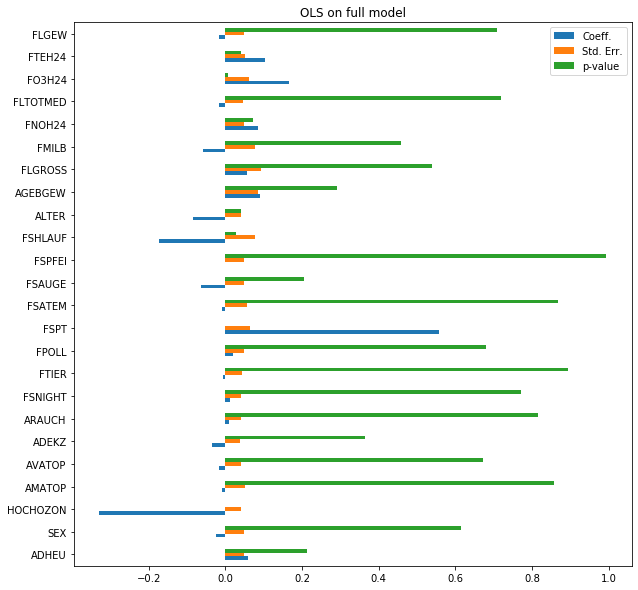

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.686
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              20.40
Date:                Fri, 15 Nov 2019   Prob (F-statistic):                    1.12e-43
Time:                        15:52:50   Log-Likelihood:                         -208.22
No. Observations:                 248   AIC:                                      464.4
Df Residuals:                     224   BIC:                                      548.8
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [69]:
model = sm.OLS(y_train, X_train)
results = model.fit() # fit model

# Evaluate MSE/R2 on the training set
y_pred = results.predict(X_train)
print_mse_and_r2(y_train, y_pred, "Training set")

# Evaluate MSE/R2 on the test set
y_pred = results.predict(X_test)
print_mse_and_r2(y_test, y_pred, "Testing set")

# Call the plot function
plot_coeff_stderr_pvalues(results, X_train, "OLS on full model", "OLS_full_model.png")

# Print a summary of the results
print(results.summary())

The covariate with the strongest association (largest absolute value of coefficient) to FFVC is:
* FSPT (assured response to an allergen), with a coefficient of 0.5558 and the lowest P-value (<0.0005).
The covariate with the weakest association is 
* FSPFEI (whistling or wheezy breath)

The P-values vary a lot, and some of the predictors with the smallest P-values are HOCHOZON, FSPT, ALTER, FNOH24, FO3H24 and FTEH24.

Most std. errors vary in the range $[0.04, 0.08]$ and:
* The predictor with the lowest std. err. is ADEKZ (neurodermatitis diagnosed by a physician)
* The predictor with the highest std. err. is FLGROSS (height at lufu)

## 1.3 Reduced models by forward selection and backward elimination

First I will create the functions which performs these model reductions given a general stopping criterion:

In [32]:
def backward_elimination(X, y, Xt, yt, p_stop_crit):
    p = p_stop_crit + 1
    iter = 0
    max_iter = len(list(X))
    X_temp = X.copy()
    while p > p_stop_crit and iter <= max_iter:
        iter += 1
        results = sm.OLS(y, X_temp).fit()
        # find covariate with largest p-value:
        covariate = np.argmax(results.pvalues)
        p = np.max(results.pvalues)
        # remove covariate from X before next iteration
        if p > p_stop_crit: # If stopping criterion is reached, keep X as it is, 
            del X_temp[covariate] # Reduce X_temp before next iteration
    
    
    # Evaluate MSE/R2 on training set
    model = sm.OLS(y, X_temp) 
    results = model.fit()
    y_pred = results.predict(X[list(X_temp)]) # training (predictors subset)
    print_mse_and_r2(y, y_pred, "Training set")
    
    # Evaluate MSE/R2 on test set
    y_pred = results.predict(Xt[list(X_temp)]) # test (predictors subset)
    print_mse_and_r2(yt, y_pred, "Testing set")
    
    # Bar plot
    plot_coeff_stderr_pvalues(results, X_temp,
        f"Backward Elimination, p > {p_stop_crit:2.2f} removed.",
        f"back_elim_p_{p_stop_crit:1.2f}.png")
    
    # Summary print
    print(results.summary())


def forward_selection(X, y, Xt, yt, p_stop_crit):
    max_p = 0
    iter = len(list(X))
    final_model = pd.DataFrame() # empty model to begin with
    X_temp = X.copy()

    while max_p < p_stop_crit and iter > 0:
        iter -= 1
        least_p_value = 10 # arbitrary large number (needed for the if test below)
        for cov in list(X_temp):
            temp_model = final_model # temporary final model (which will be built up)
            temp_model[cov] = X_temp[cov] # Add one covariate
            # Evaluate p
            results = sm.OLS(y, temp_model).fit()
            temp_p = np.min(results.pvalues[-1])
            # Check if p is the least obtained p so far:
            if temp_p < least_p_value:
                least_cov = cov
                least_p_value = temp_p
                new_col = temp_model[cov]
            # Reset temporary model
            del temp_model[cov]
            
        # max p now:
        final_model = pd.concat([final_model, X_temp[least_cov]], axis=1)
        results = sm.OLS(y, final_model).fit()
        max_p = np.max(results.pvalues)
        
        # Remove covariate from X_temp before next iteration, because this cov
        # has already been added to the final model
        del X_temp[least_cov]

    # Evaluate MSE/R2 on training set
    model = sm.OLS(y, final_model) 
    results = model.fit()
    y_pred = results.predict(X[list(final_model)]) # training (predictors subset)
    print_mse_and_r2(y, y_pred, "Training set")
    
    # Evaluate MSE/R2 on test set
    y_pred = results.predict(Xt[list(final_model)]) # test (predictors subset)
    print_mse_and_r2(yt, y_pred, "Testing set")
    
    # Bar plot
    plot_coeff_stderr_pvalues(results, final_model,
        f"Forward Selection, p < {p_stop_crit:2.2f} included.",
        f"frwd_slct_p_{p_stop_crit:1.2f}.png")
    
    # Summary print
    print(results.summary())

**First Criterion**: Only include $p < 0.05$, 
first with backward elimination:

Training set: MSE = 0.3249, R2 = 0.6751
Testing set: MSE = 0.4330, R2 = 0.6068


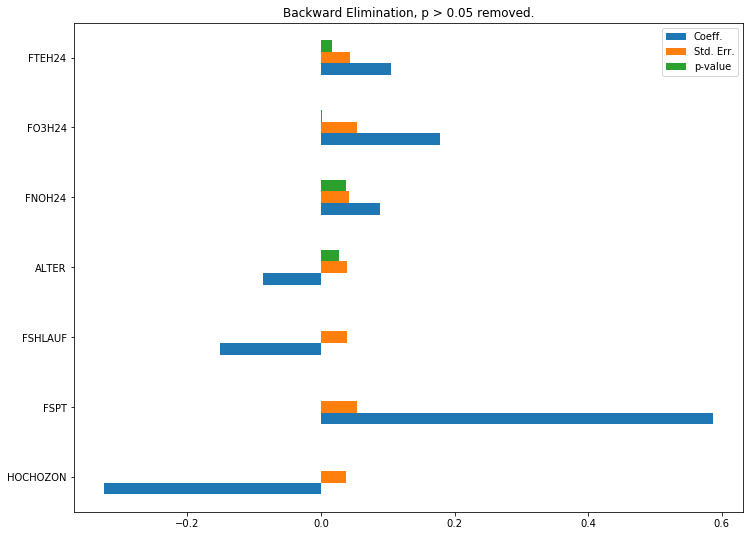

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.675
Model:                            OLS   Adj. R-squared (uncentered):              0.666
Method:                 Least Squares   F-statistic:                              71.55
Date:                Fri, 15 Nov 2019   Prob (F-statistic):                    2.71e-55
Time:                        15:51:33   Log-Likelihood:                         -212.47
No. Observations:                 248   AIC:                                      438.9
Df Residuals:                     241   BIC:                                      463.5
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [59]:
backward_elimination(X_train, y_train, X_test, y_test, 0.05)

Now with forward selection:

Training set: MSE = 0.3308, R2 = 0.6692
Testing set: MSE = 0.4319, R2 = 0.6077


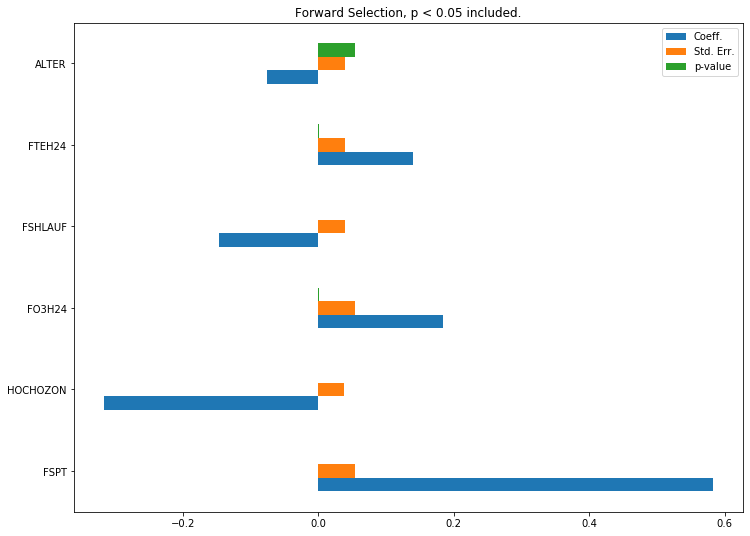

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.661
Method:                 Least Squares   F-statistic:                              81.60
Date:                Fri, 15 Nov 2019   Prob (F-statistic):                    2.47e-55
Time:                        15:51:35   Log-Likelihood:                         -214.71
No. Observations:                 248   AIC:                                      441.4
Df Residuals:                     242   BIC:                                      462.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [60]:
forward_selection(X_train, y_train, X_test, y_test, 0.05)

The two methods does not yield the same result: backward selection includes one extra predictor FNOH24. This is very possible outcome due to the difference in the methods.


New stopping criterion $p < 0.20$:

Training set: MSE = 0.3193, R2 = 0.6807
Testing set: MSE = 0.4300, R2 = 0.6095


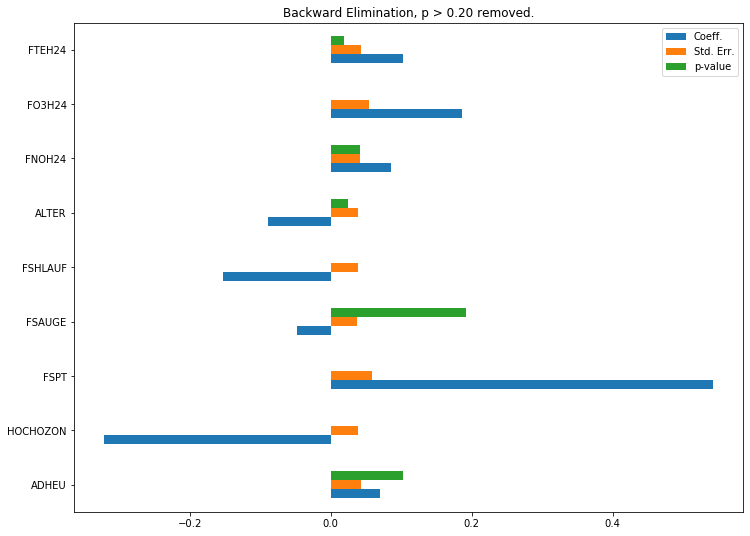

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                              56.61
Date:                Fri, 15 Nov 2019   Prob (F-statistic):                    2.55e-54
Time:                        15:51:38   Log-Likelihood:                         -210.33
No. Observations:                 248   AIC:                                      438.7
Df Residuals:                     239   BIC:                                      470.3
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [61]:
backward_elimination(X_train, y_train, X_test, y_test, 0.20)

Training set: MSE = 0.3181, R2 = 0.6819
Testing set: MSE = 0.4359, R2 = 0.6041


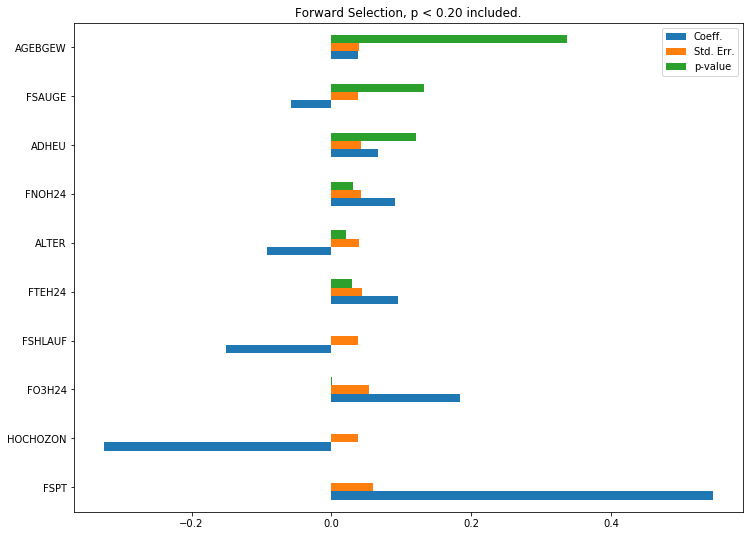

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                              51.03
Date:                Fri, 15 Nov 2019   Prob (F-statistic):                    1.26e-53
Time:                        15:51:41   Log-Likelihood:                         -209.85
No. Observations:                 248   AIC:                                      439.7
Df Residuals:                     238   BIC:                                      474.8
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [62]:
forward_selection(X_train, y_train, X_test, y_test, 0.20)

This time, the two methods chooses the exact same subsets which contained 9 predictors. However, the coefficients are not identical, but close to each other.

## 1.4 LASSO regression with k-fold CV and bootstrap



K-fold CV: best alpha = 1.000e-01
Training set: MSE = 0.3823, R2 = 0.1441
Testing set: MSE = 0.3966 R2 = 0.6079

Bootstrap: best alpha = 4.498e-09
Training set: MSE = 0.3175, R2 = 0.5029
Testing set: MSE = 0.3734 R2 = 0.6516



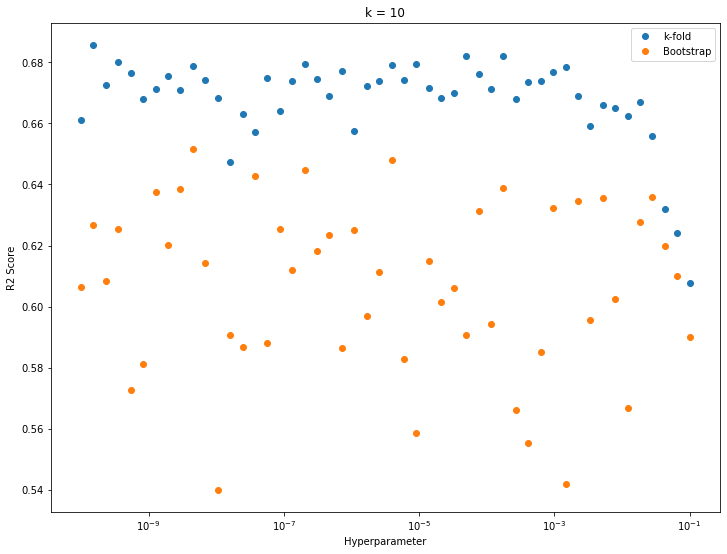

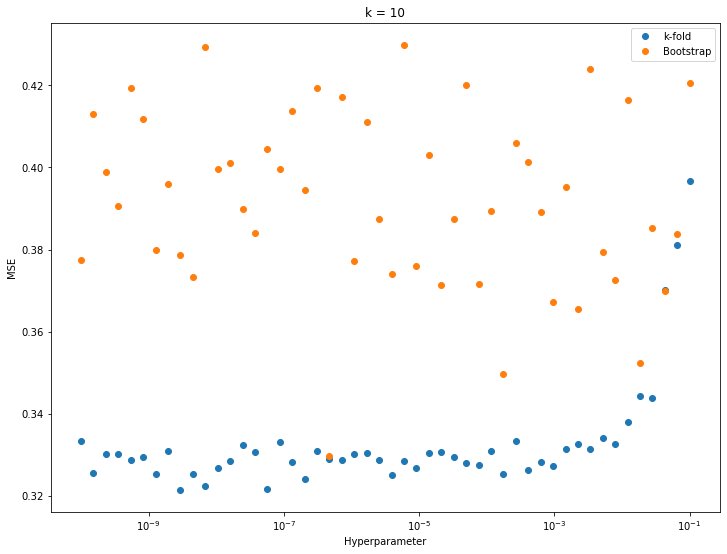

In [63]:
from sklearn.linear_model import Lasso
from math import floor

class LassoRegr:
    """
    Simple Class for LASSO
    Example:
    obj = LassoRegr(X, y)
    MSE, R2 = obj.k_fold_CV(
        k=10, 
        alpha=1e-5, 
        bootstrap=False
    )
    """
    def __init__(self, X, y):
        # store all of X, y
        self.X = X
        self.y = y
        # copies of X, y (used in CV)
        self.X_temp = X
        self.y_temp = y

    def fit(self, alpha=1e-6):
        model = Lasso(alpha=alpha)
        model.fit(self.X_temp, self.y_temp)
        p = self.X_temp.shape[1]
        self.beta = np.transpose(model.coef_)
        self.beta[0] = model.intercept_
        self.p = self.beta.shape[0]
        return None

    def predict(self, X):
        y_pred = X @ self.beta
        return y_pred
            
    def k_fold_CV(self, k, alpha, bootstrap=False):
        mse = np.zeros(k)
        r2 = np.zeros(k)
        N = self.X.shape[0]
        p = np.random.permutation(N)  # permutation array for shuffling of data
        length = floor(N / k)  # number of indices per interval k.
        for i in range(k):
            
            # Bootstrap: choose a random subset of the data
            if bootstrap: 
                entire_set = np.random.permutation(N)
                train_set = entire_set[length:]
                test_set = entire_set[:length]
                
            # K-fold: choose subsets of the data in a cyclic fashion
            else:
                start = i * length
                stop = (i + 1) * length
                train_set = np.concatenate((p[:stop], p[start:]))
                test_set = p[start:stop]
                
            # split
            X_test = self.X[test_set]
            y_test = self.y[test_set]
            self.X_temp = self.X[train_set]
            self.y_temp = self.y[train_set]
            
            # fit
            self.fit(alpha=alpha)
            
            # predict
            y_pred = self.predict(X_test)
            
            # evaluate
            mse[i] = mse_func(y_test, y_pred)
            r2[i] = r2_func(y_test, y_pred)

        # Reset temporary arrays
        self.X_temp = self.X
        self.y_temp = self.y
        
        # Evaluate mean
        MSE = np.mean(mse)
        R2 = np.mean(r2)
        
        return MSE, R2
    
    
# Compute results by using the LassoRegr-class:
n_alphas = 50
n_folds = 10
alphas = np.logspace(-10, -1, n_alphas)
kfold_scores = np.zeros(n_alphas)
bootstrap_scores = np.zeros(n_alphas)
kfold_mse = np.zeros(n_alphas)
bootstrap_mse = np.zeros(n_alphas)
X = np.concatenate((X_train.copy(), X_test.copy()), axis=0)
y = np.concatenate((y_train.copy(), y_test.copy()), axis=0)
reg = LassoRegr(X, y)
for i,alpha in enumerate(alphas):
    mse, r2 = reg.k_fold_CV(n_folds, alpha, bootstrap=False)
    kfold_mse[i] = mse
    kfold_scores[i] = r2
    mse, r2 = reg.k_fold_CV(n_folds, alpha, bootstrap=True)
    bootstrap_mse[i] = mse
    bootstrap_scores[i] = r2
    
# Prints
kfold_idx = np.argmin(kfold_scores)
kfold_alpha = alphas[kfold_idx]
bootstrap_idx = np.argmax(bootstrap_scores)
bootstrap_alpha = alphas[bootstrap_idx]

# Print K-fold
print(f"K-fold CV: best alpha = {kfold_alpha:1.3e}")
reg = LassoRegr(X_train, y_train)
reg.fit(alpha=kfold_alpha)
y_pred = reg.predict(X_train)
print_mse_and_r2(y_pred, y_train, "Training set")
print(f"Testing set: MSE = {kfold_mse[kfold_idx]:1.4f}", end=" ")
print(f"R2 = {kfold_scores[kfold_idx]:1.4f}\n")

# Print Bootstrap
print(f"Bootstrap: best alpha = {bootstrap_alpha:1.3e}")
reg.fit(alpha=bootstrap_alpha)
y_pred = reg.predict(X_train)
print_mse_and_r2(y_pred, y_train, "Training set")
print(f"Testing set: MSE = {bootstrap_mse[bootstrap_idx]:1.4f}", end=" ")
print(f"R2 = {bootstrap_scores[bootstrap_idx]:1.4f}\n")

# Plot R2 scores vs. alpha for both methods
plt.title(f"k = {n_folds}")
plt.semilogx(alphas, kfold_scores, "o", label="k-fold")
plt.semilogx(alphas, bootstrap_scores, "o", label="Bootstrap")
plt.legend()
plt.ylabel("R2 Score")
plt.xlabel("Hyperparameter")
plt.show()

# Plot MSEs vs. alpha for both methods
plt.title(f"k = {n_folds}")
plt.semilogx(alphas, kfold_mse, "o", label="k-fold")
plt.semilogx(alphas, bootstrap_mse, "o", label="Bootstrap")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Hyperparameter")
plt.show()

As can be seen in the figures, k-fold provides more stable estimates of MSE/R2 for the various regularization parameters. Bootstrap is much more dominated by stochasticity and have very varying results.

## General additive model (1) and linear regression with polynomial features (2)


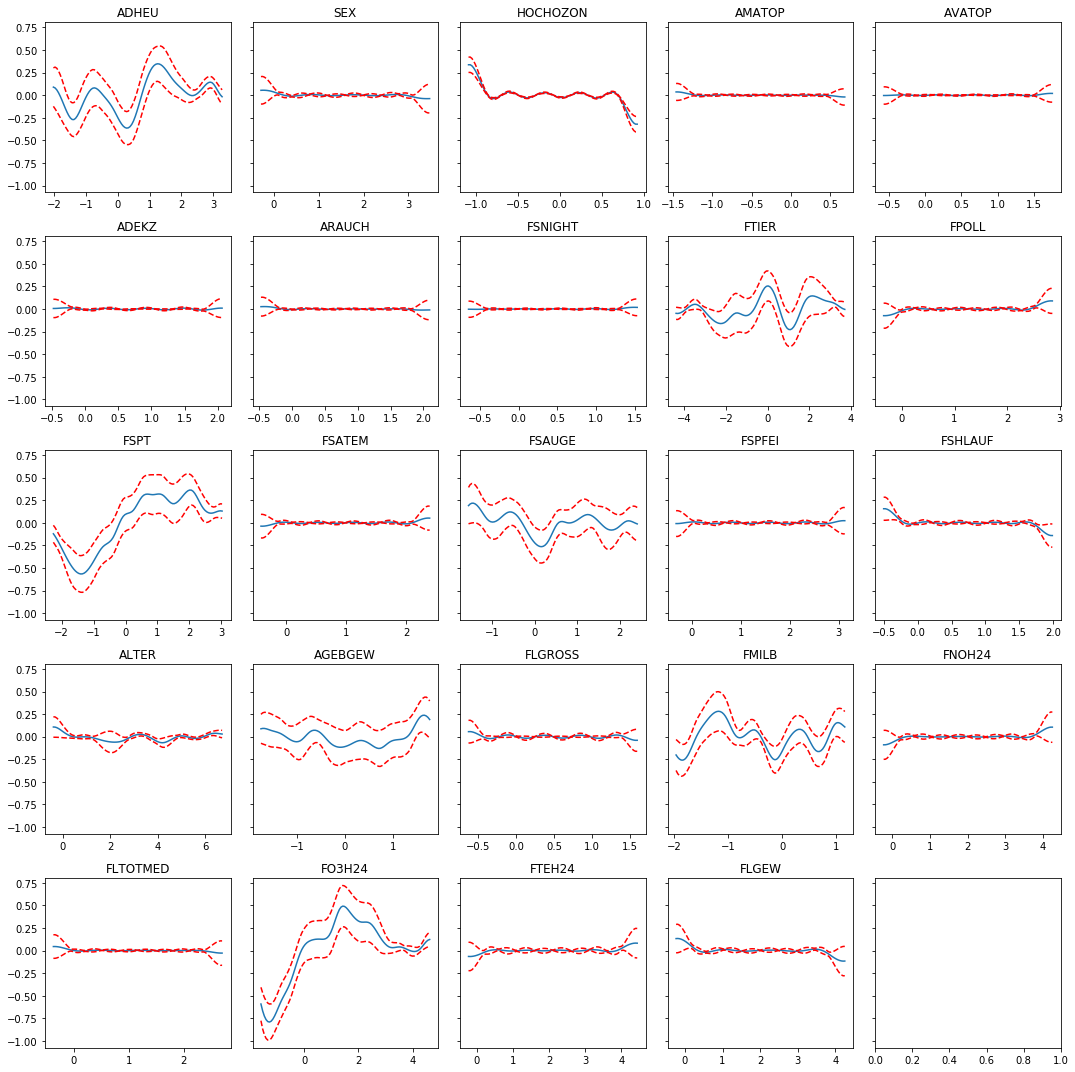

In [120]:
from pygam import LinearGAM, s, l

X = X_train.copy()
y = y_train.copy()
gam = LinearGAM().fit(X, y)
fig, axes = plt.subplots(5, 5, sharey=True, figsize=[15, 15])
axes = axes.ravel()
for i,feat in enumerate(list(X)):
    XX = gam.generate_X_grid(term=i)
    axes[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    axes[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls="--")
    axes[i].set_title(feat)
    
fig.tight_layout()
plt.show()

# by inspection of figure, these predictors look non-linear (the categorical are left undetermined)
non_linear_predictors = ["ADHEU", "FTIER", "FSPT", "FSAUGE", "FMILB", "FO3H24"] 
non_linear_idx = [0, 8, 12, 18, 21]
linear_predictors = []
for feat in list(X):
    if feat not in non_linear_predictors:
        linear_predictors.append(feat)

In [121]:
Xt = X_test.copy()
yt = y_test.copy()

for feat in non_linear_predictors:
    X[feat + "^2"] = X[feat].copy()**2
    Xt[feat + "^2"] = Xt[feat].copy()**2

    
model = sm.OLS(y, X)
results = model.fit() # fit model

# Evaluate MSE/R2 on the training set
y_pred = results.predict(X)
print(y.values.reshape(-1).shape, y_pred.shape)
print_mse_and_r2(y.values.reshape(-1), y_pred, "Training set")
y_pred = results.predict(Xt)
print_mse_and_r2(yt.values.reshape(-1), y_pred, "Test set")

(248,) (248,)
Training set: MSE = 0.3035, R2 = 0.6965
Test set: MSE = 0.4603, R2 = 0.5819


## 1.6 Boosting


In [146]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X = X_train.copy()
Xt = X_test.copy()
y = y_train.copy()
yt = y_test.copy()

print("Boosting with linear regressor")
reg = AdaBoostRegressor(base_estimator = LinearRegression())
reg.fit(X, y)
y_pred = reg.predict(X)
print_mse_and_r2(y, y_pred, "Training set")
y_pred = reg.predict(Xt)
print_mse_and_r2(yt, y_pred, "Test set")

print("Boosting with decision trees")
reg2 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), n_estimators=250) 
reg2.fit(X, y)
y_pred = reg2.predict(X)
print_mse_and_r2(y, y_pred, "Training set")
y_pred = reg2.predict(Xt)
print_mse_and_r2(yt, y_pred, "Test set")

Boosting with linear regressor
Training set: MSE = 0.3233, R2 = 0.6767
Test set: MSE = 0.4602, R2 = 0.5821
Boosting with decision trees
Training set: MSE = 0.0005, R2 = 0.9995
Test set: MSE = 0.4998, R2 = 0.5460


## 1.7 Train and test error for all models


# Exercise 2: Pima indians diabetes data set

### Processing of data set


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LogisticGAM, s, l, f
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_validate, LeaveOneOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
plt.rcParams['figure.figsize'] = [10, 10]

df = pd.read_csv("./data/PimaIndiansDiabetes.csv")

def process_dataframe(df):
    train_df, test_df = train_test_split(df, test_size=0.33, stratify=df["Outcome"])

    n_train = train_df.shape[0]
    n_test = test_df.shape[0]
    outcomes_train = np.sum(train_df["Outcome"].values)
    outcomes_test = np.sum(test_df["Outcome"].values)
    print(f" * Fraction of \"Outcome=1.0\" (train) = {outcomes_train/n_train:1.2f}")
    print(f" * Fraction of \"Outcome=1.0\" (test) = {outcomes_test/n_test:1.2f}")

    X_train = train_df.loc[:, train_df.columns != "Outcome"]
    y_train = train_df["Outcome"]
    X_test = test_df.loc[:, test_df.columns != "Outcome"]
    y_test = test_df["Outcome"]

    predictor_list = list(X_train)

    scl = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scl.transform(X_train), columns=predictor_list)
    X_test = pd.DataFrame(scl.transform(X_test), columns=predictor_list)
    return X_train, X_test, y_train, y_test, n_train, n_test

print("PimaIndiansDiabetes:")
X_train, X_test, y_train, y_test, n_train, n_test = process_dataframe(df)

# 2nd Data Set
print("\nPimaIndiansDiabetes2:")
df2 = pd.DataFrame(np.load("./data/PimaIndiansDiabetes2.npy"), columns=list(df))
df2["Outcome"] -= 1 # these values are 1 and 2 in this data set
X_train2, X_test2, y_train2, y_test2, n_train2, n_test2 = process_dataframe(df2)

PimaIndiansDiabetes:
 * Fraction of "Outcome=1.0" (train) = 0.35
 * Fraction of "Outcome=1.0" (test) = 0.35

PimaIndiansDiabetes2:
 * Fraction of "Outcome=1.0" (train) = 0.33
 * Fraction of "Outcome=1.0" (test) = 0.33


## 2.1 K-Nearest-Neighbors

The idea is to find the optimal value of K for the number of neighbors to consider. The strategy to analyze this will be by two methods:
1. Vary K and do a 5-fold CV on the training set
2. Vary K and to a loo CV

Lastly, estimate the MSE for these to methods for all K and compare with the test MSE.

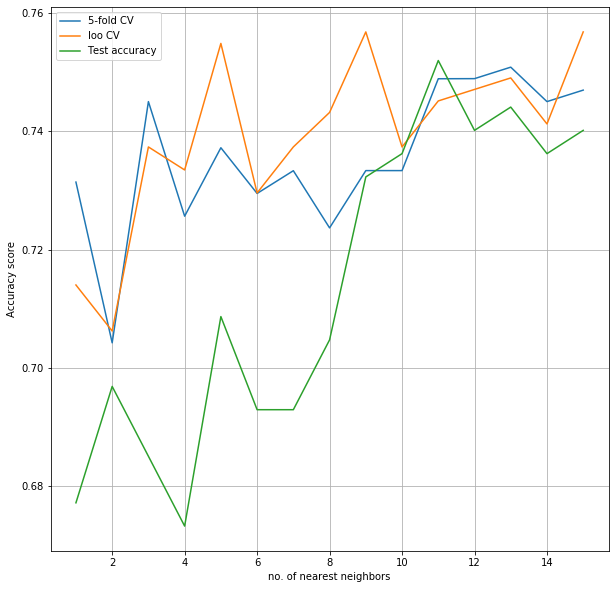

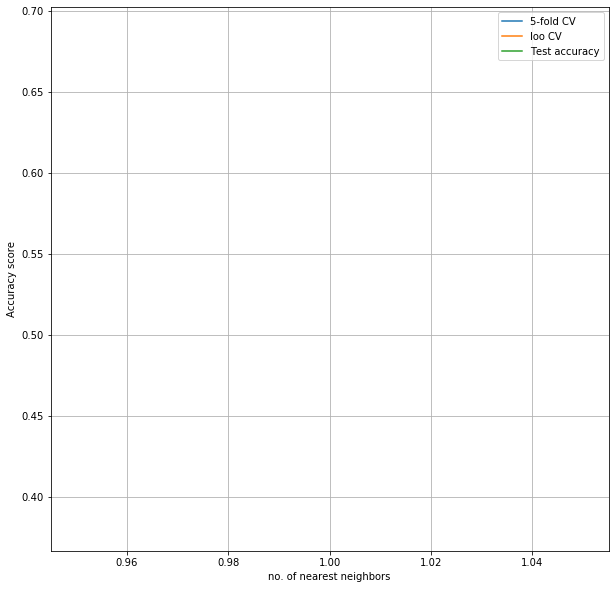

In [17]:
def k_nearest_neighbors(X, Xt, y, yt, max_num_neighbors):
    neighbors = np.arange(1, max_num_neighbors + 1, dtype=np.int32)
    score_vs_neighbors_5fold = np.zeros(max_num_neighbors)
    score_vs_neighbors_loo = np.zeros(max_num_neighbors)
    score_test_set = np.zeros(max_num_neighbors)

    for k in neighbors:
        clf = knn(n_neighbors=k)

        # 5 fold CV
        scores_this_k = cross_validate(clf, X, y, cv=5)["test_score"]
        score_vs_neighbors_5fold[k-1] = np.mean(scores_this_k)

        # Leave one out
        cv = LeaveOneOut().split(X, y)
        scores_this_k = cross_validate(clf, X, y, cv=cv)["test_score"]
        score_vs_neighbors_loo[k-1] = np.mean(scores_this_k)

        # Test score
        clf.fit(X, y)
        y_pred = clf.predict(Xt)
        score_test_set[k-1] = np.sum(y_pred == yt)/n_test

    plt.plot(neighbors, score_vs_neighbors_5fold, label="5-fold CV")
    plt.plot(neighbors, score_vs_neighbors_loo, label="loo CV")
    plt.plot(neighbors, score_test_set, label="Test accuracy")
    plt.xlabel("no. of nearest neighbors")
    plt.ylabel("Accuracy score")
    plt.legend()
    plt.grid()
    plt.show()
    
X = X_train.copy()
Xt = X_test.copy()
y = y_train.copy()
yt = y_test.copy()
k_nearest_neighbors(X, Xt, y, yt, 15)

X2 = X_train2.copy()
Xt2 = X_test2.copy()
y2 = y_train2.copy()
yt2 = y_test2.copy()
k_nearest_neighbors(X2, Xt2, y2, yt2, 1)

The test score reaches its best accuracy at 5 nearest neighbors. However, similar good scores are achieved with 9, 7 and 11 neighbors.

Both 5-fold CV and loo CV estimates the 11 nearest neighbors are optimal.

## 2.2 Generalized Additive Model with Subset Selection

In [15]:
def general_additive_model(X, Xt, y, yt, perm):

    splines = s(0)
    for i in range(1, X.shape[1]):
        splines += s(i)

    gam = LogisticGAM(splines)
    clf = gam.fit(X.values, y.values)
    # print(clf.summary()) # This summary is used to determine the p-values of each predictor
    # which again is used to make the subset selections!
    # y_pred = gam.predict(X)
    # train_acc = np.sum(y_pred == y)/n_train
    # print(f"Train accuracy = {train_acc:1.2f}")
    # y_pred = gam.predict(Xt)
    # test_acc = np.sum(y_pred == yt)/n_test
    # print(f"Test accuracy = {test_acc:1.2f}")

    X_temp = pd.DataFrame() # Start with empty models
    Xt_temp = pd.DataFrame() # Start with empty models
    predictor_list = list(X)

    for i in perm:
        X_temp[predictor_list[i]] = X[predictor_list[i]].copy() # build models by one predictor at a time
        Xt_temp[predictor_list[i]] = Xt[predictor_list[i]].copy() # build models by one predictor at a time
        gam = LogisticGAM(n_splines=10)
        clf = gam.fit(X_temp.values, y.values)
        y_pred = clf.predict(Xt_temp)
        acc = np.sum(yt == y_pred)/n_test
        print(" * Predictors:", end=" ")
        [print(feat, end=", ") for feat in list(X_temp)] # Print the name of all predictors included so far
        print(f"\n - Accuracy = {acc:1.2f}") # Print the test accuracy score for this model
        
        
# P values from lowest to largest: index 1, 5, 7, 4, 0, 6, 2, 3
print("Pima Indians Diabetes")
perm = [1, 5, 7, 4, 0, 6, 2, 3]
general_additive_model(X, Xt, y, yt, perm)

print("\nPima Indians Diabetes2")
X2 = X_train2.copy()
Xt2 = X_test2.copy()
y2 = y_train2.copy()
yt2 = y_test2.copy()
perm2 = [1, 7, 0, 4, 6, 3, 5, 2]
general_additive_model(X2, Xt2, y2, yt2, perm2)


Pima Indians Diabetes
 * Predictors: Glucose, 
 - Accuracy = 0.73
 * Predictors: Glucose, BMI, 
 - Accuracy = 0.77
 * Predictors: Glucose, BMI, Age, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, DiabetesPedigreeFunction, 
 - Accuracy = 0.77
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, DiabetesPedigreeFunction, BloodPressure, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, DiabetesPedigreeFunction, BloodPressure, SkinThickness, 
 - Accuracy = 0.77

Pima Indians Diabetes2
 * Predictors: Glucose, 
 - Accuracy = 0.40
 * Predictors: Glucose, Age, 
 - Accuracy = 0.39
 * Predictors: Glucose, Age, Pregnancies, 
 - Accuracy = 0.39
 * Predictors: Glucose, Age, Pregnancies, Insulin, 
 - Accuracy = 0.39
 * Predictors: Glucose, Age, Pregnancies, Insulin, DiabetesPedigreeFunction, 
 - Accuracy =

The subsets which includes 3-4 predictors with the lowest p-values: Glucose, BMI, Age (and Insuling) provide the highest accuracy scores of 0.82.

## 2.3 Six Various Methods
* Classification tree
* Bagging (probability votes)
* Bagging (consensus votes)
* Random forest
* Neural network
* AdaBoost

All of these will be used to classify the outcome (diabetes=True/False). The methods will be evaluated by using accuracy scores.


In [16]:
def classifier_comparisson(X, Xt, y, yt): 
    clfs = [
        DecisionTreeClassifier, 
        BaggingClassifier,
        RandomForestClassifier, 
        MLPClassifier,
        AdaBoostClassifier
    ]

    clf_params = [
        {},
        {},
        {"n_estimators": 100},
        {"hidden_layer_sizes": (100, 66, 40, 25, 16), "max_iter": 10000},
        {}
    ]

    names = [
        "Decision Tree    ",
        "Bagging (prob.)  ",
        "Random Forest    ",
        "Neural Network   ",
        "AdaBoosting      "
    ]


    for clf, params, name in zip(clfs, clf_params, names):
        # Average over 10 runs:
        score = 0
        for i in range(10):
            model = clf( **params).fit(X, y)
            score += model.score(Xt, yt)/10
        # Print results:
        print(name, f": Test accuracy score = {score:1.3f}")

    # Voting classifier
    clf1 = DecisionTreeClassifier()
    clf2 = RandomForestClassifier(n_estimators=100)
    clf3 = AdaBoostClassifier()
    clf4 = LogisticRegression(solver='lbfgs')

    clf = VotingClassifier(estimators=[
        ('dt', clf1), 
        ('rf', clf2),
        ('ab', clf3),
        ('lr', clf4)
    ])

    clf.fit(X, y)
    score = clf.score(Xt, yt)
    print(f"Voting Classifier : Test accuracy score = {score:1.3f}")
    
    
print("Pima Indians Diabetes")
classifier_comparisson(X, Xt, y, yt)

print("\nPima Indians Diabetes2")  
classifier_comparisson(X2, Xt2, y2, yt2)

Pima Indians Diabetes
Decision Tree     : Test accuracy score = 0.673
Bagging (prob.)   : Test accuracy score = 0.742
Random Forest     : Test accuracy score = 0.759
Neural Network    : Test accuracy score = 0.713
AdaBoosting       : Test accuracy score = 0.709
Voting Classifier : Test accuracy score = 0.752

Pima Indians Diabetes2
Decision Tree     : Test accuracy score = 0.722
Bagging (prob.)   : Test accuracy score = 0.758
Random Forest     : Test accuracy score = 0.792
Neural Network    : Test accuracy score = 0.762
AdaBoosting       : Test accuracy score = 0.769
Voting Classifier : Test accuracy score = 0.777


## 2.4 Method of Choice
Out of all the results, the ***Random Forest*** seems to provide the best accuracy score for the test set. 

## 2.5 New, Fixed Data Set